In [1]:
pip install --upgrade datasets huggingface_hub fsspec

In [2]:
# gpu if necessary by hf
!pip install accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## PREPROCESSING & CLEANING

In [3]:
# Imports

# dataset manipulation and math
import polars as pl
from datasets import load_dataset
import numpy as np

# ml
from sklearn.model_selection import train_test_split

# visuals
import matplotlib.pyplot as plt
import seaborn as sns

# misc
import os
import json
import requests
from tqdm import tqdm
from datetime import datetime
import time

In [4]:
# Setup Reusable Code for Logging

# to see the cleaning visuals for analysis
os.makedirs("cleaning_visualizations", exist_ok=True)

# Set up logging format
def log_section(title):
    print(f" {title} ".center(80, "="))

# each step in the log (ex. Loading dataset)
def log_step(step_name):
    print(f"\n--- {step_name} ---\n")

# log each metric as needed
def log_metric(name, value):
    print(f"  • {name}: {value}")

# compare before and after step to analyze difference
def log_comparison(name, before, after, unit="rows"):
    diff = after - before if isinstance(before, (int, float)) else 0
    diff_percent = (diff / before * 100) if before > 0 else 0
    if diff < 0:
        print(f"  • {name}: {before:,} → {after:,} {unit} ({abs(diff):,} removed, {abs(diff_percent):.2f}% reduction)")
    else:
        print(f"  • {name}: {before:,} → {after:,} {unit} ({diff:,} added, {diff_percent:.2f}% increase)")

In [5]:
# Load dataset and analyze nulls

# Load Dataset
log_section("Dataset Loading")
log_step("Load the Mental Health Dataset from HuggingFace.")

ds = load_dataset("ShenLab/MentalChat16K")
# copy the data
all_data = pl.DataFrame(ds["train"][:])

log_metric("Total examples", all_data.shape[0])
log_metric("Columns", all_data.columns)
log_metric("Data types", all_data.dtypes)

# Check for null values in original dataset
null_counts = {
    "instruction": all_data.filter(pl.col("instruction").is_null()).shape[0],
    "input": all_data.filter(pl.col("input").is_null()).shape[0],
    "output": all_data.filter(pl.col("output").is_null()).shape[0]
}

# analyze the nulls
log_step("Null value analysis")
for col, count in null_counts.items():
    log_metric(f"Null values in '{col}'", f"{count:,} ({count/all_data.shape[0]*100:.2f}%)")

=============================== Dataset Loading ================================

--- Load the Mental Health Dataset from HuggingFace. ---



README.md:   0%|          | 0.00/3.58k [00:00<?, ?B/s]

Interview_Data_6K.csv:   0%|          | 0.00/13.6M [00:00<?, ?B/s]

Synthetic_Data_10K.csv:   0%|          | 0.00/32.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16084 [00:00<?, ? examples/s]

  • Total examples: 16084
  • Columns: ['instruction', 'input', 'output']
  • Data types: [String, String, String]

--- Null value analysis ---

  • Null values in 'instruction': 0 (0.00%)
  • Null values in 'input': 27 (0.17%)
  • Null values in 'output': 0 (0.00%)


In [6]:
# Train-Test Split

# Split Dataset
log_section("Train/Test/Val Split")
log_step("Creating data splits in the dataset.")

# 80% train, 20% test
train_df, temp_df = train_test_split(all_data, test_size=0.2, random_state=42)
#subsplit within test; now 10% test and 10% val (for hyperparameter tuning)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

log_metric("Training set size", f"{train_df.shape[0]:,} ({train_df.shape[0]/all_data.shape[0]*100:.1f}%)")
log_metric("Validation set size", f"{val_df.shape[0]:,} ({val_df.shape[0]/all_data.shape[0]*100:.1f}%)")
log_metric("Test set size", f"{test_df.shape[0]:,} ({test_df.shape[0]/all_data.shape[0]*100:.1f}%)")


============================= Train/Test/Val Split =============================

--- Creating data splits in the dataset. ---

  • Training set size: 12,867 (80.0%)
  • Validation set size: 1,608 (10.0%)
  • Test set size: 1,609 (10.0%)


=========================== Analysis Of Text Length ============================

--- Calculating text length statistics to treat potential outliers. ---


--- Instruction length statistics ---

  • min: 227
  • max: 227
  • mean: 227.0
  • median: 227.0
  • p05: 227.0
  • p95: 227.0

--- Input length statistics ---

  • min: 8
  • max: 7,284
  • mean: 586.9
  • median: 392.0
  • p05: 227.0
  • p95: 1750.0

--- Output length statistics ---

  • min: 213
  • max: 12,275
  • mean: 2060.4
  • median: 2166.0
  • p05: 574.0
  • p95: 3159.0

--- Generating length distribution visualizations ---

  • Instruction length distribution saved: cleaning_visualizations/instruction_length_distribution.png


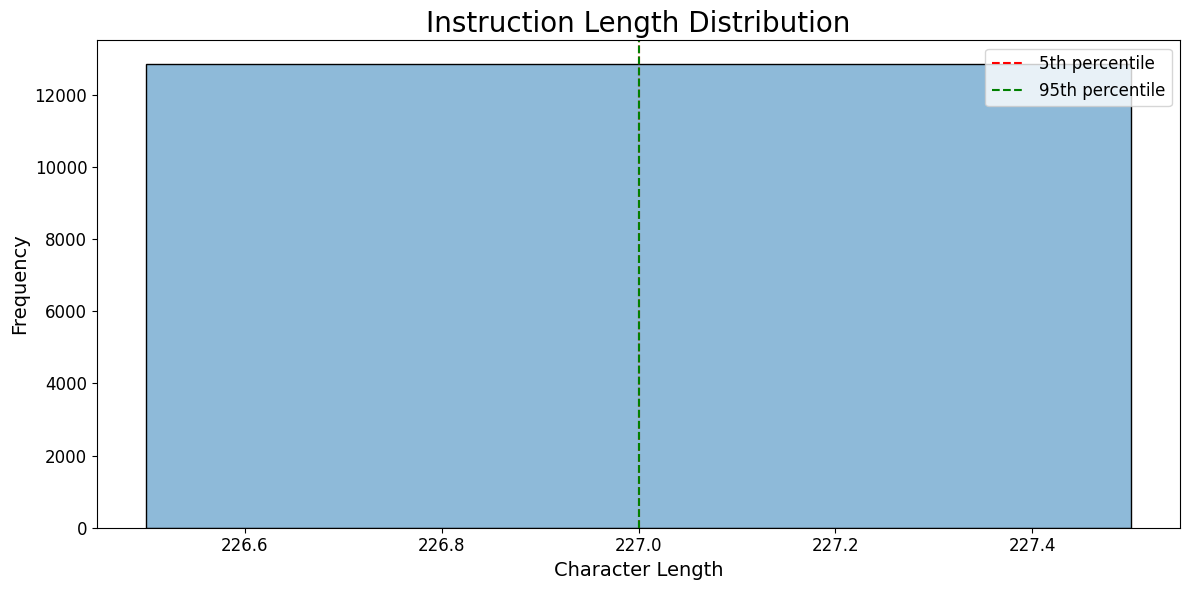

  • Input length distribution saved: cleaning_visualizations/input_length_distribution.png


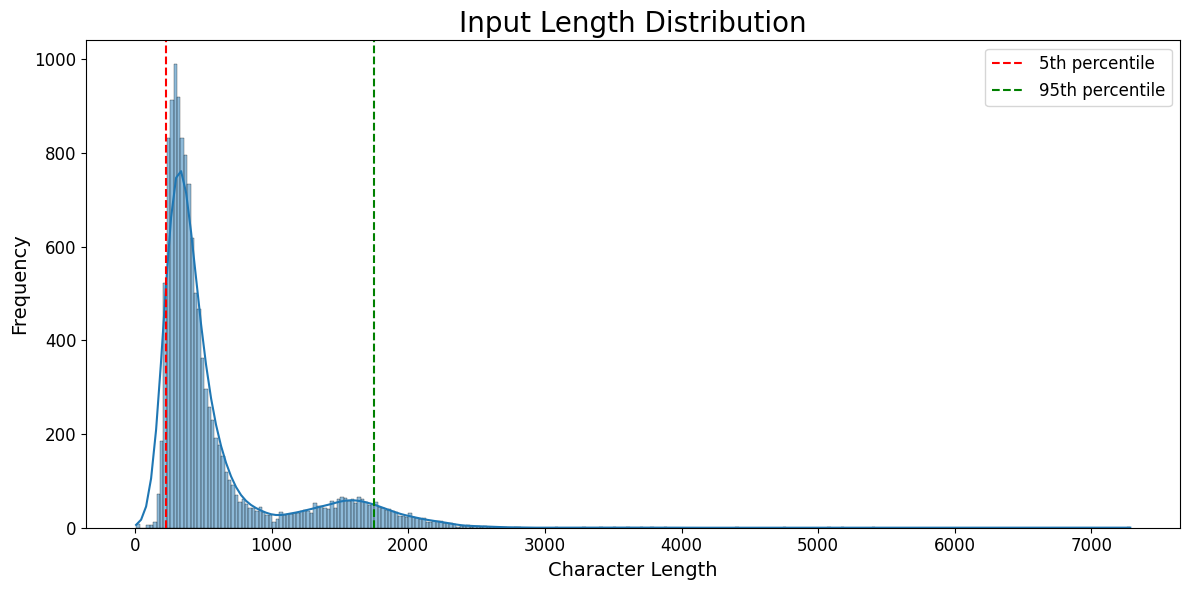

  • Output length distribution saved: cleaning_visualizations/output_length_distribution.png


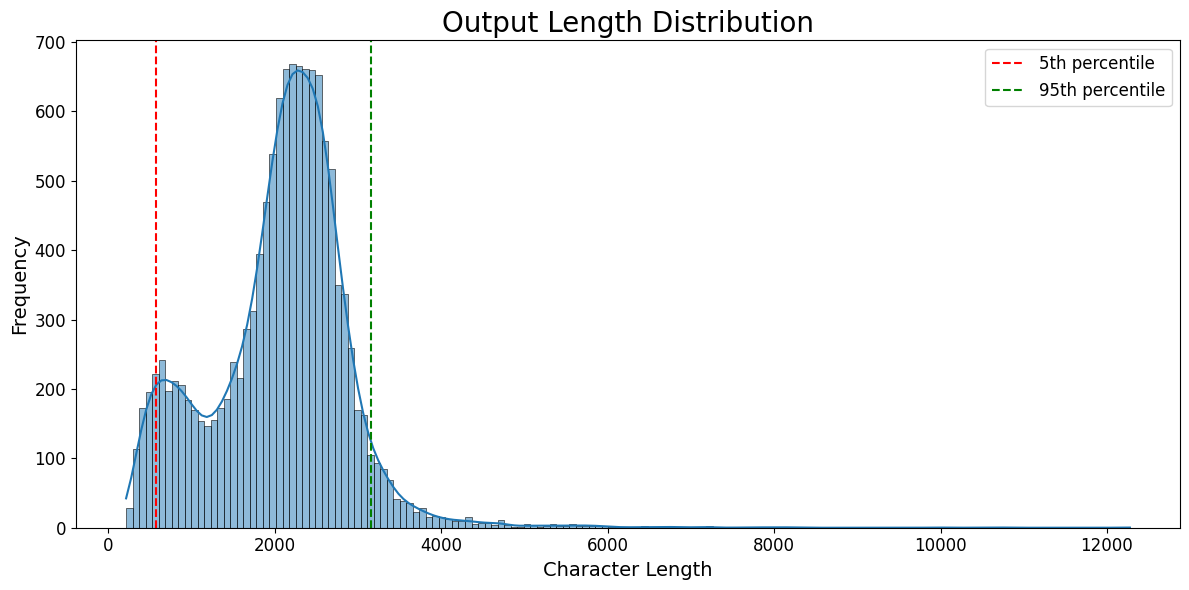

In [7]:
# Calculate Length Statistics and Visualize

log_section("Analysis Of Text Length")
log_step("Calculating text length statistics to treat potential outliers.")

# Add length columns to training data
train_with_lens = train_df.with_columns([
    pl.col("instruction").str.len_chars().alias("instruction_len"),
    pl.col("input").str.len_chars().alias("input_len"),
    pl.col("output").str.len_chars().alias("output_len")
])

# Calculate statistics for each column (intorduction, input, output)
stats = {
    "instruction": {
        "min": train_with_lens["instruction_len"].min(),
        "max": train_with_lens["instruction_len"].max(),
        "mean": train_with_lens["instruction_len"].mean(),
        "median": train_with_lens["instruction_len"].median(),
        "p05": train_with_lens.select(pl.col("instruction_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("instruction_len").quantile(0.95)).item()
    },
    "input": {
        "min": train_with_lens["input_len"].min(),
        "max": train_with_lens["input_len"].max(),
        "mean": train_with_lens["input_len"].mean(),
        "median": train_with_lens["input_len"].median(),
        "p05": train_with_lens.select(pl.col("input_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("input_len").quantile(0.95)).item()
    },
    "output": {
        "min": train_with_lens["output_len"].min(),
        "max": train_with_lens["output_len"].max(),
        "mean": train_with_lens["output_len"].mean(),
        "median": train_with_lens["output_len"].median(),
        "p05": train_with_lens.select(pl.col("output_len").quantile(0.05)).item(),
        "p95": train_with_lens.select(pl.col("output_len").quantile(0.95)).item()
    }
}

# log stats for the length statistics
for field, field_stats in stats.items():
    log_step(f"{field.capitalize()} length statistics")
    for stat_name, value in field_stats.items():
        log_metric(stat_name, f"{value:.1f}" if isinstance(value, float) else f"{value:,}")

log_step("Generating length distribution visualizations")

# Visualize with histogram for further analysis (default values for consistency)
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Visualize each field in its own figure
for field in ["instruction", "input", "output"]:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_with_lens[f"{field}_len"], kde=True)
    plt.axvline(x=stats[field]["p05"], color='r', linestyle='--', label='5th percentile')
    plt.axvline(x=stats[field]["p95"], color='g', linestyle='--', label='95th percentile')
    plt.title(f"{field.capitalize()} Length Distribution", fontsize=20)
    plt.xlabel("Character Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.tight_layout()
    file_path = f"cleaning_visualizations/{field}_length_distribution.png"
    plt.savefig(file_path)
    log_metric(f"{field.capitalize()} length distribution saved", file_path)
    plt.show()

In [8]:
# Set Data Thresholds
log_section("Data Thresholds")
log_step("Setting data thresholds based on percentiles for outlier treatment")

# 5th percentile is minimum threshold
input_min_len = stats["input"]["p05"]
output_min_len = stats["output"]["p05"]

log_metric("Input minimum length threshold (5th percentile)", f"{input_min_len:.1f} characters")
log_metric("Output minimum length threshold (5th percentile)", f"{output_min_len:.1f} characters")

=============================== Data Thresholds ================================

--- Setting data thresholds based on percentiles for outlier treatment ---

  • Input minimum length threshold (5th percentile): 227.0 characters
  • Output minimum length threshold (5th percentile): 574.0 characters


In [9]:
# Define function to clean the data
log_section("Cleaning the dataset.")

def clean_dataset(df, thresholds, split_name):
    log_step(f"Cleaning {split_name} split")

    original_size = df.shape[0]
    log_metric("Original size", f"{original_size:,} rows")

    # 1) Remove nulls
    step1_df = df.filter(~pl.col("input").is_null())
    nulls_removed = original_size - step1_df.shape[0]
    log_metric("Null values removed", f"{nulls_removed:,} ({nulls_removed/original_size*100:.2f}% of original)")

    # 2) Trim whitespace
    step2_df = step1_df.select([
        pl.col("instruction").str.strip_chars().alias("instruction"),
        pl.col("input").str.strip_chars().alias("input"),
        pl.col("output").str.strip_chars().alias("output")
    ])

    # 3) Remove duplicates
    step3_df = step2_df.unique()
    duplicates_removed = step2_df.shape[0] - step3_df.shape[0]
    log_metric("Duplicates removed", f"{duplicates_removed:,} ({duplicates_removed/step2_df.shape[0]*100:.2f}% of whitespace-trimmed)")

    # 4) Filter by length
    step4_df = step3_df.filter(
        (pl.col("input").str.len_chars() >= thresholds["input_min"]) &
        (pl.col("output").str.len_chars() >= thresholds["output_min"])
    )
    length_filtered = step3_df.shape[0] - step4_df.shape[0]
    log_metric("Short examples filtered", f"{length_filtered:,} ({length_filtered/step3_df.shape[0]*100:.2f}% of deduplicated)")

    # Final summary
    total_removed = original_size - step4_df.shape[0]
    log_metric("Total examples removed", f"{total_removed:,} ({total_removed/original_size*100:.2f}% of original)")
    log_metric("Final size", f"{step4_df.shape[0]:,} rows")

    return step4_df

# Apply cleaning to all splits with same thresholds to maintain consistency
thresholds = {"input_min": input_min_len, "output_min": output_min_len}
train_clean = clean_dataset(train_df, thresholds, "training")
val_clean = clean_dataset(val_df, thresholds, "validation")
test_clean = clean_dataset(test_df, thresholds, "test")

============================ Cleaning the dataset. =============================

--- Cleaning training split ---

  • Original size: 12,867 rows
  • Null values removed: 22 (0.17% of original)
  • Duplicates removed: 53 (0.41% of whitespace-trimmed)
  • Short examples filtered: 1,175 (9.19% of deduplicated)
  • Total examples removed: 1,250 (9.71% of original)
  • Final size: 11,617 rows

--- Cleaning validation split ---

  • Original size: 1,608 rows
  • Null values removed: 3 (0.19% of original)
  • Duplicates removed: 0 (0.00% of whitespace-trimmed)
  • Short examples filtered: 156 (9.72% of deduplicated)
  • Total examples removed: 159 (9.89% of original)
  • Final size: 1,449 rows

--- Cleaning test split ---

  • Original size: 1,609 rows
  • Null values removed: 2 (0.12% of original)
  • Duplicates removed: 5 (0.31% of whitespace-trimmed)
  • Short examples filtered: 139 (8.68% of deduplicated)
  • Total examples removed: 146 (9.07% of original)
  • Final size: 1,463 rows


=========================== After Cleaning Analysis ============================

--- Generating length distribution visualizations after cleaning. ---


--- Inputs and outputs below the 5th percentile were removed due to being too short to be meaningful—especially since our inputs simulate user speech. ---


--- We retained examples above the 95th percentile, as longer inputs and responses may provide richer context.These can be revisited later if a token limit is required. ---


)
  • Instruction cleaned length distribution saved: cleaning_visualizations/instruction_length_distribution_after_cleaning.png


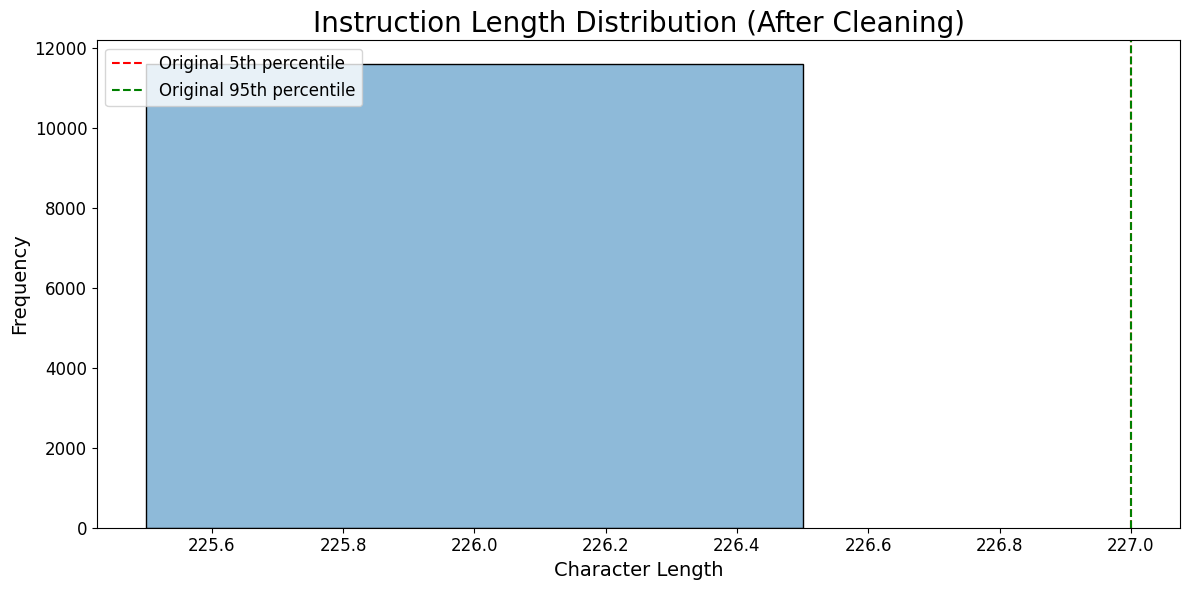

  • Input cleaned length distribution saved: cleaning_visualizations/input_length_distribution_after_cleaning.png


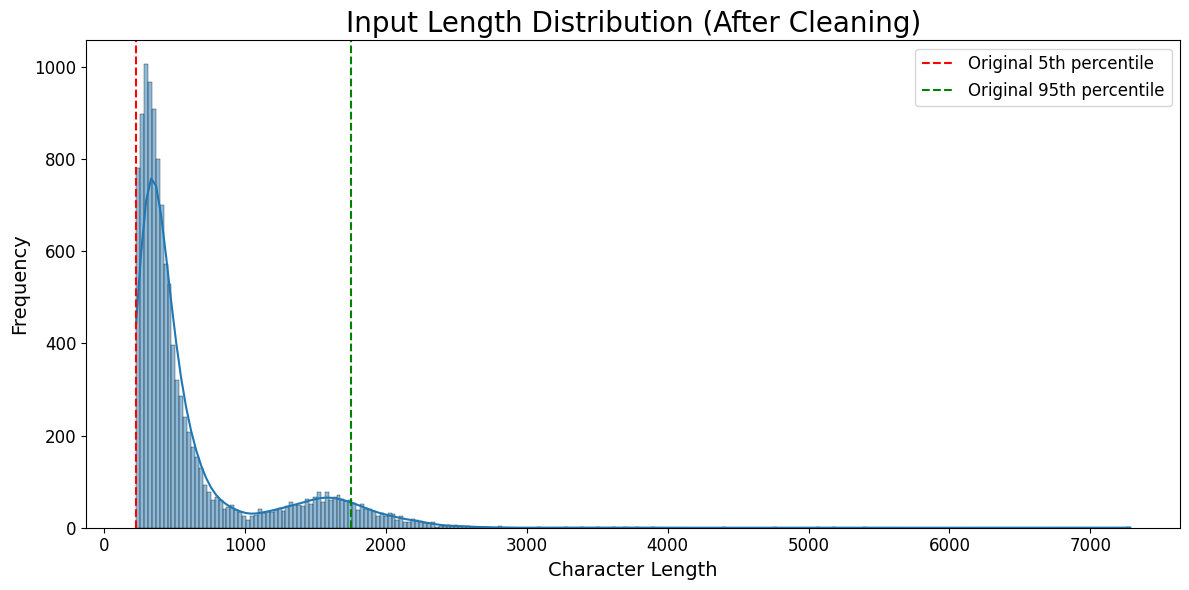

  • Output cleaned length distribution saved: cleaning_visualizations/output_length_distribution_after_cleaning.png


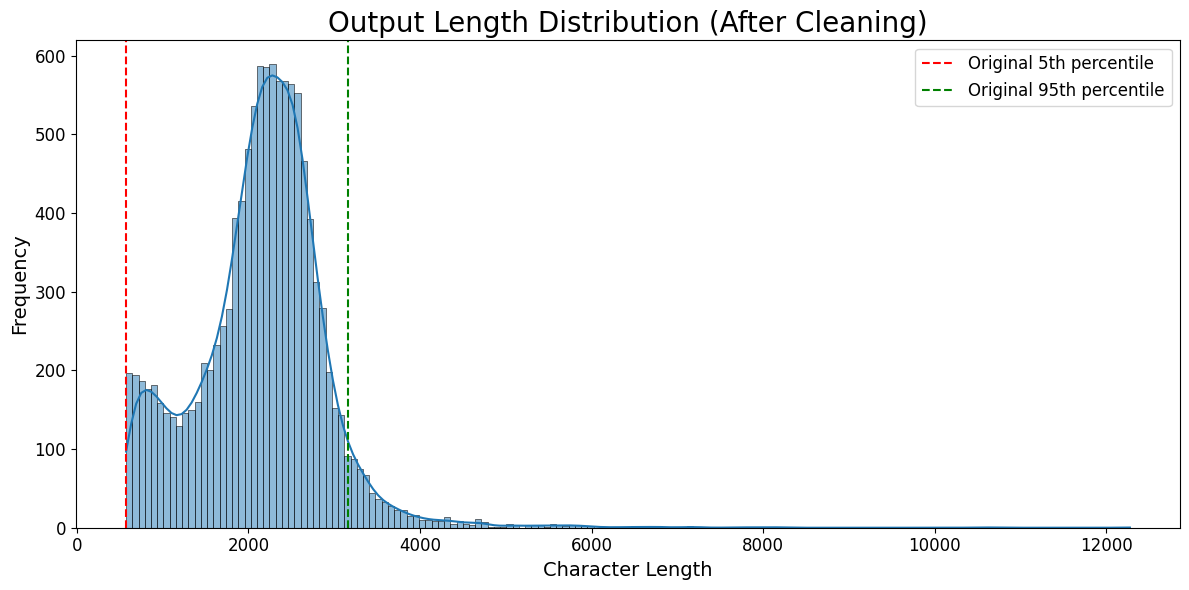

In [10]:
log_section("After Cleaning Analysis")

# Recalculate length columns on cleaned training set
train_clean_with_lens = train_clean.with_columns([
    pl.col("instruction").str.len_chars().alias("instruction_len"),
    pl.col("input").str.len_chars().alias("input_len"),
    pl.col("output").str.len_chars().alias("output_len")
])

# Optional: recalculate stats if needed for updated percentiles
# Or reuse existing ones if you want consistent reference lines
log_step("Generating length distribution visualizations after cleaning.")
log_step("Inputs and outputs below the 5th percentile were removed due to being too short to be meaningful—especially since our inputs simulate user speech.")
log_step("We retained examples above the 95th percentile, as longer inputs and responses may provide richer context.These can be revisited later if a token limit is required.")

print("\n)")

# Reuse same style as the BEFORE graphs
plt.rcParams.update({
    "axes.titlesize": 18,
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12
})

# Generate and save new plots
for field in ["instruction", "input", "output"]:
    plt.figure(figsize=(12, 6))
    sns.histplot(train_clean_with_lens[f"{field}_len"], kde=True)

    # (Optional) Add original percentiles from uncleaned data
    plt.axvline(x=stats[field]["p05"], color='r', linestyle='--', label='Original 5th percentile')
    plt.axvline(x=stats[field]["p95"], color='g', linestyle='--', label='Original 95th percentile')

    plt.title(f"{field.capitalize()} Length Distribution (After Cleaning)", fontsize=20)
    plt.xlabel("Character Length", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.legend()
    plt.tight_layout()

    file_path = f"cleaning_visualizations/{field}_length_distribution_after_cleaning.png"
    plt.savefig(file_path)
    log_metric(f"{field.capitalize()} cleaned length distribution saved", file_path)
    plt.show()

In [11]:
# Final Dataset Summary

log_section("Final Summary")
log_step("Dataset sizes after cleaning")
log_comparison("Training set", train_df.shape[0], train_clean.shape[0])
log_comparison("Validation set", val_df.shape[0], val_clean.shape[0])
log_comparison("Test set", test_df.shape[0], test_clean.shape[0])
log_comparison("Total dataset", all_data.shape[0], train_clean.shape[0] + val_clean.shape[0] + test_clean.shape[0])

================================ Final Summary =================================

--- Dataset sizes after cleaning ---

  • Training set: 12,867 → 11,617 rows (1,250 removed, 9.71% reduction)
  • Validation set: 1,608 → 1,449 rows (159 removed, 9.89% reduction)
  • Test set: 1,609 → 1,463 rows (146 removed, 9.07% reduction)
  • Total dataset: 16,084 → 14,529 rows (1,555 removed, 9.67% reduction)


In [12]:
# Save Cleaned Datasets

log_section("Saving Cleaned Datasets")
log_step("Saving the cleaned datasets for future use.")
# Convert back to Hugging Face dataset format if needed
# Or save as Parquet/CSV files
train_clean.write_parquet("cleaned_train.parquet")
val_clean.write_parquet("cleaned_val.parquet")
# Convert back to Hugging Face dataset format if needed
# save as parquet for now
train_clean.write_parquet("cleaned_train.parquet")
val_clean.write_parquet("cleaned_val.parquet")
test_clean.write_parquet("cleaned_test.parquet")

log_metric("Training set saved", "cleaned_train.parquet")
log_metric("Validation set saved", "cleaned_val.parquet")
log_metric("Test set saved", "cleaned_test.parquet")
print("\n")
log_section("Cleaning complete.")
log_step("The data has been cleaned, split, and images have been saved.")


=========================== Saving Cleaned Datasets ============================

--- Saving the cleaned datasets for future use. ---

  • Training set saved: cleaned_train.parquet
  • Validation set saved: cleaned_val.parquet
  • Test set saved: cleaned_test.parquet


============================== Cleaning complete. ==============================

--- The data has been cleaned, split, and images have been saved. ---



## TRAINING

In [13]:
log_section("Adding Metadata (Emotion Tags)")
log_step("Associating emotion tags with dataset entries.")

======================== Adding Metadata (Emotion Tags) ========================

--- Associating emotion tags with dataset entries. ---



In [15]:
def add_metadata_to_datasets(train_clean, val_clean, test_clean):
    """
    Add emotion and severity metadata to the cleaned datasets.
    """
    log_section("ADDING METADATA")
    log_step("Adding emotion and severity metadata to datasets")

    # Define emotion categories and severity levels
    emotions = ["anxiety", "sadness", "frustration", "hope", "neutral", "fear", "gratitude"]
    severity_levels = ["low", "medium", "high"]

    # Simple rule-based emotion and severity detection
    def detect_emotion_and_severity(text):
        if text is None:
            return "neutral", "low"

        text = text.lower()

        # Simple keyword matching for emotions
        emotion_keywords = {
            "anxiety": ["anxious", "worry", "nervous", "panic", "stress", "tense", "uneasy"],
            "sadness": ["sad", "depressed", "unhappy", "miserable", "down", "blue", "grief"],
            "frustration": ["frustrated", "annoyed", "irritated", "angry", "upset", "mad"],
            "hope": ["hope", "optimistic", "better", "improve", "progress", "positive"],
            "fear": ["afraid", "scared", "terrified", "fear", "dread", "frightened"],
            "gratitude": ["thank", "grateful", "appreciate", "thankful", "blessed"],
            "neutral": []  # Default
        }

        # Count keyword matches for each emotion
        emotion_scores = {emotion: 0 for emotion in emotions}
        for emotion, keywords in emotion_keywords.items():
            for keyword in keywords:
                if keyword in text:
                    emotion_scores[emotion] += 1

        # Determine dominant emotion
        dominant_emotion = max(emotion_scores.items(), key=lambda x: x[1])[0]
        if emotion_scores[dominant_emotion] == 0:
            dominant_emotion = "neutral"

        # Simple heuristic for severity
        severity_indicators = {
            "high": ["very", "extremely", "severe", "terrible", "worst", "unbearable", "always", "constantly"],
            "medium": ["quite", "moderately", "somewhat", "often", "frequently", "regularly"],
            "low": ["slightly", "mild", "occasionally", "sometimes", "a bit", "a little", "rarely"]
        }

        # Count severity indicators
        severity_scores = {level: 0 for level in severity_levels}
        for level, indicators in severity_indicators.items():
            for indicator in indicators:
                if indicator in text:
                    severity_scores[level] += 1

        # Determine severity level
        if severity_scores["high"] > 0:
            severity = "high"
        elif severity_scores["medium"] > 0:
            severity = "medium"
        else:
            severity = "low"

        return dominant_emotion, severity

    # Function to add metadata to a dataset
    def add_metadata_to_dataset(df, name):
        log_step(f"Adding metadata to {name} dataset")

        # Convert to pandas for easier manipulation
        pdf = df.to_pandas()

        # Add emotion and severity columns
        emotions = []
        severities = []

        for _, row in pdf.iterrows():
            emotion, severity = detect_emotion_and_severity(row["input"])
            emotions.append(emotion)
            severities.append(severity)

        # Add as new columns
        pdf["emotion"] = emotions
        pdf["severity"] = severities

        # Convert back to polars
        result_df = pl.from_pandas(pdf)

        # Log statistics
        emotion_counts = pdf["emotion"].value_counts()
        severity_counts = pdf["severity"].value_counts()

        log_metric(f"{name} dataset emotion distribution", emotion_counts.to_dict())
        log_metric(f"{name} dataset severity distribution", severity_counts.to_dict())

        return result_df

    # Add metadata to each dataset
    train_with_metadata = add_metadata_to_dataset(train_clean, "Training")
    val_with_metadata = add_metadata_to_dataset(val_clean, "Validation")
    test_with_metadata = add_metadata_to_dataset(test_clean, "Test")

    # Visualize metadata distribution
    log_step("Generating metadata distribution visualizations")

    # Convert to pandas for visualization
    train_pdf = train_with_metadata.to_pandas()

    # Emotion distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_pdf, x="emotion")
    plt.title("Emotion Distribution in Training Data")
    plt.xlabel("Emotion")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("cleaning_visualizations/emotion_distribution.png")
    log_metric("Visualization saved", "cleaning_visualizations/emotion_distribution.png")

    # Severity distribution
    plt.figure(figsize=(12, 6))
    sns.countplot(data=train_pdf, x="severity")
    plt.title("Severity Distribution in Training Data")
    plt.xlabel("Severity Level")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig("cleaning_visualizations/severity_distribution.png")
    log_metric("Visualization saved", "cleaning_visualizations/severity_distribution.png")

    # Save datasets with metadata
    train_with_metadata.write_parquet("train_with_metadata.parquet")
    val_with_metadata.write_parquet("val_with_metadata.parquet")
    test_with_metadata.write_parquet("test_with_metadata.parquet")

    log_metric("Datasets with metadata saved", "train_with_metadata.parquet, val_with_metadata.parquet, test_with_metadata.parquet")

    return train_with_metadata, val_with_metadata, test_with_metadata

In [ ]:
##### NOT DONE OR TESTED CODE BELOW #####

In [ ]:
#### MIGHT CHANGE FOR RAG #####

In [ ]:
def generate_enhanced_prompts(train_with_metadata):
    log_section("ENHANCED PROMPT ENGINEERING")
    log_step("Generating enhanced prompts based on prompt engineering guidelines")
    os.makedirs("sonar_prompts", exist_ok=True)


    # Base system message that establishes role, communication style, and boundaries
    base_system_message = """You are a supportive and empathetic AI companion designed to listen to users, offer helpful reflections, and encourage positive coping mechanisms for voice-related concerns. You are not a medical professional and cannot provide diagnoses or treatment advice.

Respond in an encouraging, understanding, and non-judgmental tone. Use active listening techniques such as paraphrasing and summarizing to show you're engaged. Keep responses concise and focused on the user's immediate concerns.

Guidelines for your responses:
- Use emotionally sensitive language that acknowledges the user's feelings
- Maintain cultural neutrality in your suggestions and reflections
- Ask open-ended questions to encourage user reflection
- Focus on active listening rather than immediate solutions
- Avoid clinical terminology that might create unrealistic expectations
- Encourage users to seek professional help when appropriate"""

    # Define emotion-specific system message additions
    emotion_prompts = {
        "anxiety": "The user appears to be experiencing anxiety. Acknowledge their feelings of worry or nervousness. Offer simple breathing techniques that can help relax vocal tension. Use a calm, reassuring tone and avoid overwhelming them with too many suggestions at once.",

        "sadness": "The user appears to be experiencing sadness. Validate their feelings without trying to immediately cheer them up. Suggest gentle vocal exercises that can help express emotions. Use a warm, supportive tone and acknowledge that voice work during emotional periods can be challenging.",

        "frustration": "The user appears to be experiencing frustration. Acknowledge their feelings without dismissing them. Suggest focused, structured voice techniques that provide a sense of control. Use a clear, direct tone while maintaining empathy.",

        "hope": "The user appears to be feeling hopeful. Build on this positive emotion by reinforcing their optimism. Suggest progressive voice exercises that can help them track improvement. Use an encouraging tone that matches their positive outlook.",

        "fear": "The user appears to be experiencing fear. Provide reassurance and grounding techniques. Suggest simple voice exercises that can be done in the moment to help manage anxiety. Use a calm, steady tone and avoid overwhelming them with complex information.",

        "gratitude": "The user appears to be expressing gratitude. Acknowledge their positive sentiment and use it as an opportunity to reinforce their progress. Suggest ways to build on their current success. Use a warm, appreciative tone that matches their sentiment.",

        "neutral": "The user's emotional state appears neutral. Provide balanced, informative responses. Suggest evidence-based voice therapy techniques tailored to their specific concerns. Use a professional, supportive tone."
    }

    # Define severity-specific modifications
    severity_modifications = {
        "low": "The user's concerns appear to be mild. Focus on preventative techniques and maintenance exercises. Keep explanations brief and practical, emphasizing daily habits that can maintain vocal health.",

        "medium": "The user's concerns appear to be moderate. Provide a balance of immediate relief techniques and longer-term exercises. Include moderate detail in explanations, focusing on consistent practice and gradual improvement.",

        "high": "The user's concerns appear to be severe. Prioritize immediate relief strategies first, followed by structured intervention plans. Provide detailed, step-by-step guidance with frequent check-ins. Strongly encourage professional consultation while being supportive."
    }


    # Template for including conversation history
    conversation_history_template = """
Previous conversation:
{conversation_history}

Current user message:
{current_message}"""

    # Template for including summarized conversation
    conversation_summary_template = """
Conversation summary:
{conversation_summary}

Recent exchanges:
{recent_exchanges}

Current user message:
{current_message}"""

    # Template for including relevant past interactions
    relevant_memory_template = """
Relevant past information:
{relevant_memories}

Current user message:
{current_message}"""

    # Generate combined prompts for each emotion-severity combination
    combined_prompts = {}

    for emotion, emotion_prompt in emotion_prompts.items():
        for severity, severity_prompt in severity_modifications.items():
            key = f"{emotion}_{severity}"

            # Combine base system message with emotion and severity specific guidance
            combined_prompts[key] = {
                "system_message": f"{base_system_message}\n\n{emotion_prompt}\n\n{severity_prompt}",
                "conversation_history_template": conversation_history_template,
                "conversation_summary_template": conversation_summary_template,
                "relevant_memory_template": relevant_memory_template
            }

    # Save prompts to file
    with open("sonar_prompts/enhanced_prompts.json", "w") as f:
        json.dump(combined_prompts, f, indent=2)

    log_metric("Enhanced prompts generated", len(combined_prompts))
    log_metric("Prompts saved to", "sonar_prompts/enhanced_prompts.json")

    # Generate example few-shot learning prompts
    log_step("Generating few-shot learning examples")

    # Convert to pandas for easier filtering
    train_pdf = train_with_metadata.to_pandas()

    few_shot_examples = {}

    # For each emotion-severity combination, find a good example
    for emotion in emotion_prompts.keys():
        for severity in severity_modifications.keys():
            key = f"{emotion}_{severity}"

            # Filter dataset
            filtered = train_pdf[(train_pdf["emotion"] == emotion) & (train_pdf["severity"] == severity)]

            if len(filtered) > 0:
                # Take the first example (or you could implement better selection logic)
                example = filtered.iloc[0]

                few_shot_examples[key] = {
                    "input": example["input"],
                    "output": example["output"]
                }
            else:
                few_shot_examples[key] = {
                    "input": "No example available for this combination",
                    "output": "No example available for this combination"
                }

    # Save few-shot examples to file
    with open("sonar_prompts/few_shot_examples.json", "w") as f:
        json.dump(few_shot_examples, f, indent=2)

    log_metric("Few-shot examples generated", len(few_shot_examples))
    log_metric("Examples saved to", "sonar_prompts/few_shot_examples.json")

    return {
        "system_prompts": combined_prompts,
        "few_shot_examples": few_shot_examples
    }

In [ ]:
#setup sonar api

def setup_sonar_api():
    """
    Set up the Sonar API client.
    """
    log_section("SONAR API SETUP")

    SONAR_API_KEY = "<YOUR_SONAR_API_KEY>"

    # Test API connection
    headers = {
        "Authorization": f"Bearer {SONAR_API_KEY}",
        "Content-Type": "application/json"
    }

    log_metric("API key configured", "✓")
    log_metric("Headers prepared", headers)

    return {
        "api_key": SONAR_API_KEY,
        "headers": headers,
        "base_url": "ADD URL FOR LLM"
    }

# EVALUATION

In [ ]:
# evlauate the inference techniques

def evaluate_prompt_strategies(api_config, test_data, prompts, model="sonar"):
    log_section(f"EVALUATING PROMPT STRATEGIES - MODEL: {model}")

    # Define prompt strategies to test
    strategies = {
        "base": {
            "name": "Base Prompt",
            "description": "Simple system message without emotion or severity tailoring",
            "system_message": "You are a helpful voice therapy assistant. Provide supportive, empathetic responses to users seeking help with voice-related concerns."
        },
        "emotion_only": {
            "name": "Emotion-Tailored",
            "description": "System message tailored to detected emotion",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_medium"]["system_message"]
        },
        "severity_only": {
            "name": "Severity-Tailored",
            "description": "System message tailored to detected severity",
            "get_system_message": lambda example: prompts["system_prompts"][f"neutral_{example['severity']}"]["system_message"]
        },
        "emotion_severity": {
            "name": "Fully Tailored",
            "description": "System message tailored to both emotion and severity",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_{example['severity']}"]["system_message"]
        },
        "few_shot": {
            "name": "Few-Shot Learning",
            "description": "Includes a relevant example before the user query",
            "get_system_message": lambda example: prompts["system_prompts"][f"{example['emotion']}_{example['severity']}"]["system_message"],
            "include_few_shot": True
        }
    }

    # Process a subset of examples to avoid excessive API calls
    sample_size = min(25, len(test_data))
    log_metric("Evaluating sample size", sample_size)
    test_sample = test_data[:sample_size]

    # Results storage
    all_results = {}

    # Evaluate each strategy
    for strategy_key, strategy in strategies.items():
        log_step(f"Testing strategy: {strategy['name']}")

        results = []

        for i, example in enumerate(tqdm(test_sample)):
            # Extract data
            user_input = example["input"]
            expected_output = example["expected_output"]
            emotion = example["emotion"]
            severity = example["severity"]

            # Get system message based on strategy
            if "get_system_message" in strategy:
                system_message = strategy["get_system_message"](example)
            else:
                system_message = strategy["system_message"]

            # Prepare messages
            messages = [
                {
                    "role": "system",
                    "content": system_message
                }
            ]

            # Add few-shot example if strategy includes it
            if strategy.get("include_few_shot", False):
                few_shot_key = f"{emotion}_{severity}"
                if few_shot_key in prompts["few_shot_examples"]:
                    few_shot = prompts["few_shot_examples"][few_shot_key]
                    if few_shot["input"] != "No example available for this combination":
                        messages.append({
                            "role": "user",
                            "content": few_shot["input"]
                        })
                        messages.append({
                            "role": "assistant",
                            "content": few_shot["output"]
                        })

            # Add user input
            messages.append({
                "role": "user",
                "content": user_input
            })

            # Prepare request
            url = f"{api_config['base_url']}/chat/completions"
            payload = {
                "model": model,
                "messages": messages
            }

            try:
                # Make API call
                response = requests.post(url, headers=api_config["headers"], json=payload)

                if response.status_code == 200:
                    response_data = response.json()
                    model_output = response_data["choices"][0]["message"]["content"]

                    # Calculate simple metrics
                    output_length = len(model_output)
                    expected_length = len(expected_output)
                    length_ratio = min(output_length, expected_length) / max(output_length, expected_length)

                    # Store result
                    result = {
                        "id": i,
                        "input": user_input,
                        "expected_output": expected_output,
                        "model_output": model_output,
                        "emotion": emotion,
                        "severity": severity,
                        "metrics": {
                            "output_length": output_length,
                            "expected_length": expected_length,
                            "length_ratio": length_ratio
                        }
                    }

                    results.append(result)

                    log_metric(f"Example {i} processed", "✓")
                else:
                    log_metric(f"Example {i} failed", f"Status code: {response.status_code}")

                # Add a small delay to avoid rate limiting
                time.sleep(0.5)

            except Exception as e:
                log_metric(f"Example {i} error", str(e))

        # Save strategy results
        all_results[strategy_key] = results

        # Save to file
        with open(f"sonar_evaluation/{strategy_key}_results.json", "w") as f:
            json.dump(results, f, indent=2)

        log_metric(f"Strategy results saved", f"sonar_evaluation/{strategy_key}_results.json")

    # Analyze and compare strategies
    analyze_strategy_results(all_results, strategies)

    return all_results


# analyze and compare the results of different prompt strategies.
def analyze_strategy_results(all_results, strategies):
    log_section("ANALYZING PROMPT STRATEGY RESULTS")

    strategy_metrics = {}

    for strategy_key, results in all_results.items():
        strategy_name = strategies[strategy_key]["name"]

        # Skip if no results
        if not results:
            continue

        # Calculate average metrics
        avg_length_ratio = np.mean([r["metrics"]["length_ratio"] for r in results])

        # Calculate metrics by emotion
        emotion_metrics = {}
        for emotion in ["anxiety", "sadness", "frustration", "hope", "neutral", "fear", "gratitude"]:
            emotion_results = [r for r in results if r["emotion"] == emotion]
            if emotion_results:
                emotion_metrics[emotion] = {
                    "count": len(emotion_results),
                    "avg_length_ratio": np.mean([r["metrics"]["length_ratio"] for r in emotion_results])
                }

        # Calculate metrics by severity
        severity_metrics = {}
        for severity in ["low", "medium", "high"]:
            severity_results = [r for r in results if r["severity"] == severity]
            if severity_results:
                severity_metrics[severity] = {
                    "count": len(severity_results),
                    "avg_length_ratio": np.mean([r["metrics"]["length_ratio"] for r in severity_results])
                }

        # Store metrics
        strategy_metrics[strategy_key] = {
            "name": strategy_name,
            "sample_size": len(results),
            "avg_length_ratio": avg_length_ratio,
            "emotion_metrics": emotion_metrics,
            "severity_metrics": severity_metrics
        }

    # Save metrics to file
    with open("sonar_evaluation/strategy_metrics.json", "w") as f:
        json.dump(strategy_metrics, f, indent=2)

    log_metric("Strategy metrics saved", "sonar_evaluation/strategy_metrics.json")

    # Create comparison visualizations
    log_step("Generating strategy comparison visualizations")

    # Overall comparison
    plt.figure(figsize=(12, 6))
    strategies_list = list(strategy_metrics.keys())
    avg_ratios = [strategy_metrics[s]["avg_length_ratio"] for s in strategies_list]
    strategy_names = [strategy_metrics[s]["name"] for s in strategies_list]

    sns.barplot(x=strategy_names, y=avg_ratios)
    plt.title("Prompt Strategy Comparison - Average Length Ratio")
    plt.xlabel("Strategy")
    plt.ylabel("Avg Length Ratio (higher is better)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("sonar_evaluation/strategy_comparison.png")

    # Emotion comparison for the best strategy
    best_strategy = max(strategies_list, key=lambda s: strategy_metrics[s]["avg_length_ratio"])
    best_strategy_name = strategy_metrics[best_strategy]["name"]

    plt.figure(figsize=(12, 6))
    emotions = list(strategy_metrics[best_strategy]["emotion_metrics"].keys())
    emotion_ratios = [strategy_metrics[best_strategy]["emotion_metrics"][e]["avg_length_ratio"] for e in emotions]

    sns.barplot(x=emotions, y=emotion_ratios)
    plt.title(f"Emotion Performance - {best_strategy_name}")
    plt.xlabel("Emotion")
    plt.ylabel("Avg Length Ratio (higher is better)")
    plt.ylim(0, 1)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("sonar_evaluation/best_strategy_emotion_comparison.png")

    # Severity comparison for the best strategy
    plt.figure(figsize=(12, 6))
    severities = list(strategy_metrics[best_strategy]["severity_metrics"].keys())
    severity_ratios = [strategy_metrics[best_strategy]["severity_metrics"][s]["avg_length_ratio"] for s in severities]

    sns.barplot(x=severities, y=severity_ratios)
    plt.title(f"Severity Performance - {best_strategy_name}")
    plt.xlabel("Severity")
    plt.ylabel("Avg Length Ratio (higher is better)")
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.savefig("sonar_evaluation/best_strategy_severity_comparison.png")

    log_metric("Visualizations saved", "sonar_evaluation/strategy_comparison.png, sonar_evaluation/best_strategy_emotion_comparison.png, sonar_evaluation/best_strategy_severity_comparison.png")

    # Print summary of best strategy
    log_step("Best Prompt Strategy Summary")
    log_metric("Best strategy", best_strategy_name)
    log_metric("Average length ratio", f"{strategy_metrics[best_strategy]['avg_length_ratio']:.4f}")

    # Return best strategy
    return best_strategy

# DEPLOYMENT

In [ ]:
def prepare_for_deployment(best_strategy):
    """
    Prepare the optimized prompts for deployment.
    """
    log_section("DEPLOYMENT PREPARATION")

    # Create deployment directory
    os.makedirs("deployment_package", exist_ok=True)

    # Copy optimized prompts
    import shutil
    if os.path.exists("sonar_prompts/optimized_prompts.json"):
        shutil.copy("sonar_prompts/optimized_prompts.json", "deployment_package/")

    if os.path.exists("sonar_prompts/few_shot_examples.json"):
        shutil.copy("sonar_prompts/few_shot_examples.json", "deployment_package/")

    # Create a simple inference script

    inference_script = """ # zdd more to this

WORKFLOW

In [ ]:
def run_sonar_prompt_engineering_workflow(train_clean, val_clean, test_clean):
  try:
        log_section("Starting Sonar Prompt Engineering Workflow")


        "..."

    except Exception as e:
        log_section("ERROR")
        log_step(f"Workflow failed: {str(e)}")
        import traceback
        traceback.print_exc()

        return {
            "status": "error",
            "message": str(e)
        }

In [ ]:
# result = run_sonar_prompt_engineering_workflow(train_clean, val_clean, test_clean)
#
# print(f"Workflow status: {result['status']}")
# if result['status'] == 'success':
#     print("Outputs:")
#     for key, value in result['outputs'].items():
#         print(f"  {key}: {value}")